# 라이브러리 불러오기

In [ ]:
# 통계 모델들, fbprophet 설치
!pip install statsmodels==0.11.1
!pip install fbprophet

     |████████████████████████████████| 8.7MB 8.6MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
import warnings
import datetime
warnings.filterwarnings("ignore")

# 데이터 불러오기 

In [ ]:
# csv파일 읽어오기
path = '/content/drive/MyDrive/contest/bitcoin'
train_x_df = pd.read_csv(path  + "/train_x_df.csv")
train_y_df = pd.read_csv(path  + "/train_y_df.csv")
test_x_df = pd.read_csv(path  + "/test_x_df.csv")

In [ ]:
print(f'train_x shape: {train_x_df.shape}')
print(f'train_y shape: {train_y_df.shape}')
print(f'test_x shape: {test_x_df.shape}')

train_x shape: (10159560, 12)
train_y shape: (883440, 12)
test_x shape: (730020, 12)


In [ ]:
print(train_x_df.head())
print('-------------------------------------------------------------')
print(train_x_df.info())
print('-------------------------------------------------------------')
print(train_x_df.describe())
# print(train_x_df.isnull().sum()) NULL 값 없음 확인완료

   sample_id  time  coin_index  ...      trades    tb_base_av    tb_quote_av
0          0     0           7  ...  451.157288  7.326834e+05   37725.183594
1          0     1           7  ...   39.231071  0.000000e+00       0.000000
2          0     2           7  ...   58.846603  1.664967e+04     857.377808
3          0     3           7  ...  431.541779  2.189147e+06  112811.046875
4          0     4           7  ...  176.539810  0.000000e+00       0.000000

[5 rows x 12 columns]
-------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10159560 entries, 0 to 10159559
Data columns (total 12 columns):
 #   Column       Dtype  
---  ------       -----  
 0   sample_id    int64  
 1   time         int64  
 2   coin_index   int64  
 3   open         float64
 4   high         float64
 5   low          float64
 6   close        float64
 7   volume       float64
 8   quote_av     float64
 9   trades       float64
 10  tb_base_av   float64


In [ ]:
print(train_y_df.head())
print('-------------------------------------------------------------')
print(train_y_df.info())
print('-------------------------------------------------------------')
print(train_y_df.describe())
# print(train_y_df.isnull().sum()) NULL 값 없음 확인완료

   sample_id  time  coin_index  ...      trades    tb_base_av   tb_quote_av
0          0     0           7  ...  137.308746  8.305119e+05  42356.179688
1          0     1           7  ...  294.233032  4.882738e+05  24909.861328
2          0     2           7  ...   58.846603  5.113770e+05  26100.681641
3          0     3           7  ...  137.308746  1.095514e+06  55921.156250
4          0     4           7  ...  666.928162  9.911239e+05  50528.589844

[5 rows x 12 columns]
-------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883440 entries, 0 to 883439
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   sample_id    883440 non-null  int64  
 1   time         883440 non-null  int64  
 2   coin_index   883440 non-null  int64  
 3   open         883440 non-null  float64
 4   high         883440 non-null  float64
 5   low          883440 non-null  float64
 6  

In [ ]:
print(test_x_df.head())
print('-------------------------------------------------------------')
print(test_x_df.info())
print('-------------------------------------------------------------')
print(test_x_df.describe())
# print(test_x_df.isnull().sum()) NULL 값 없음 확인완료

   sample_id  time  coin_index  ...      trades     tb_base_av    tb_quote_av
0          0     0           7  ...  332.671570  287449.968750  107758.375000
1          0     1           7  ...  407.790955  560290.250000  210005.125000
2          0     2           7  ...  276.332031  214270.265625   80283.554688
3          0     3           7  ...  166.335785   56401.246094   21135.490234
4          0     4           7  ...  303.160370  138711.703125   52010.964844

[5 rows x 12 columns]
-------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730020 entries, 0 to 730019
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   sample_id    730020 non-null  int64  
 1   time         730020 non-null  int64  
 2   coin_index   730020 non-null  int64  
 3   open         730020 non-null  float64
 4   high         730020 non-null  float64
 5   low          730020 non-null  

# EDA // 데이터 전처리

In [ ]:
# 상관계수 확인
corr_x = train_x_df.corr(method ="pearson")
corr_x

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
sample_id,1.000000,0.000000e+00,4.278576e-03,-0.011692,-0.011690,-0.011662,-0.011676,-0.000407,0.010186,0.009696,-0.000393,0.009447
time,0.000000,1.000000e+00,3.894486e-18,-0.012273,-0.012346,-0.012248,-0.012289,-0.000277,-0.000464,-0.000708,-0.000444,-0.000394
coin_index,0.004279,3.894486e-18,1.000000e+00,-0.010498,-0.010721,-0.010341,-0.010520,0.006909,0.000136,0.010454,0.006393,-0.000206
open,-0.011692,-1.227325e-02,-1.049803e-02,1.000000,0.998631,0.999254,0.999071,0.009158,0.025290,0.022769,0.004867,0.019132
high,-0.011690,-1.234571e-02,-1.072102e-02,0.998631,1.000000,0.997830,0.998898,0.014944,0.033986,0.032518,0.011817,0.029751
low,-0.011662,-1.224846e-02,-1.034080e-02,0.999254,0.997830,1.000000,0.999315,0.002101,0.014780,0.011092,0.001434,0.012224
close,-0.011676,-1.228935e-02,-1.052042e-02,0.999071,0.998898,0.999315,1.000000,0.008074,0.024175,0.021432,0.007229,0.022276
volume,-0.000407,-2.768361e-04,6.909391e-03,0.009158,0.014944,0.002101,0.008074,1.000000,0.420857,0.573042,0.794751,0.372958
quote_av,0.010186,-4.641555e-04,1.357815e-04,0.025290,0.033986,0.014780,0.024175,0.420857,1.000000,0.826307,0.344711,0.920649
trades,0.009696,-7.075427e-04,1.045373e-02,0.022769,0.032518,0.011092,0.021432,0.573042,0.826307,1.000000,0.466903,0.754661


In [ ]:
corr_y = train_y_df.corr(method ="pearson")
corr_y

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
sample_id,1.000000,0.000000e+00,4.278576e-03,-0.001195,-0.000799,-0.001522,-0.000991,-0.001144,0.008835,0.006470,-0.000310,0.008538
time,0.000000,1.000000e+00,-5.054400e-21,0.003800,0.003148,0.004450,0.003753,-0.000989,-0.001685,-0.002170,-0.002156,-0.002411
coin_index,0.004279,-5.054400e-21,1.000000e+00,-0.002687,-0.003532,-0.002090,-0.002722,0.006538,-0.003210,0.007859,0.005997,-0.003572
open,-0.001195,3.800312e-03,-2.686648e-03,1.000000,0.993176,0.992726,0.991055,0.019498,0.034898,0.034660,0.023497,0.039227
high,-0.000799,3.147511e-03,-3.531888e-03,0.993176,1.000000,0.985593,0.993624,0.036652,0.061292,0.064435,0.044354,0.071560
low,-0.001522,4.449805e-03,-2.090215e-03,0.992726,0.985593,1.000000,0.993612,-0.001162,0.002478,-0.001718,0.013639,0.018443
close,-0.000991,3.753107e-03,-2.721523e-03,0.991055,0.993624,0.993612,1.000000,0.017120,0.031818,0.030984,0.031256,0.049745
volume,-0.001144,-9.893845e-04,6.537747e-03,0.019498,0.036652,-0.001162,0.017120,1.000000,0.413802,0.572350,0.795492,0.365074
quote_av,0.008835,-1.685352e-03,-3.210465e-03,0.034898,0.061292,0.002478,0.031818,0.413802,1.000000,0.822412,0.339014,0.918006
trades,0.006470,-2.169733e-03,7.859498e-03,0.034660,0.064435,-0.001718,0.030984,0.572350,0.822412,1.000000,0.480647,0.746228


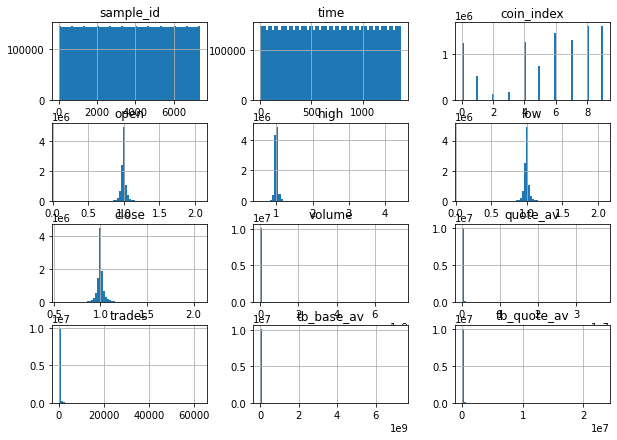

In [ ]:
# 시각화 1, 히스토그램
train_x_df.hist(bins=70, figsize=(10,7))
plt.show()

In [ ]:
'''
# 시각화2, 산점도
fig, axes = plt.subplots(2, 3, figsize=(10,7))
train_x_df.plot(x='time', y='open', kind='scatter', alpha=0.1, ax=axes[0,0])
train_x_df.plot(x='volume', y='open', kind='scatter', alpha=0.1, ax=axes[0,1])
train_x_df.plot(x='trades', y='open', kind='scatter', alpha=0.1, ax=axes[0,2])
train_x_df.plot(x='quote_av', y='open', kind='scatter', alpha=0.1, ax=axes[1,0])
train_x_df.plot(x='tb_base_av', y='open', kind='scatter', alpha=0.1, ax=axes[1,1])
train_x_df.plot(x='tb_quote_av', y='open', kind='scatter', alpha=0.1, ax=axes[1,2])

fig.tight_layout()
'''

"\n# 시각화2, 산점도\nfig, axes = plt.subplots(2, 3, figsize=(10,7))\ntrain_x_df.plot(x='time', y='open', kind='scatter', alpha=0.1, ax=axes[0,0])\ntrain_x_df.plot(x='volume', y='open', kind='scatter', alpha=0.1, ax=axes[0,1])\ntrain_x_df.plot(x='trades', y='open', kind='scatter', alpha=0.1, ax=axes[0,2])\ntrain_x_df.plot(x='quote_av', y='open', kind='scatter', alpha=0.1, ax=axes[1,0])\ntrain_x_df.plot(x='tb_base_av', y='open', kind='scatter', alpha=0.1, ax=axes[1,1])\ntrain_x_df.plot(x='tb_quote_av', y='open', kind='scatter', alpha=0.1, ax=axes[1,2])\n\nfig.tight_layout()\n"

주문량, 거래량, 거래 건 수 등에서 0값이 포함된 데이터는 지워주기로 결정.

- volume, trades, quote_av, tb_base_av, tb_quote_av 

데이터 형태를 2차원에서 3차원 Numpy array로 바꾸는 과정 중 문제가 발생. 

따라서 지우지 않는 방향으로 다시 모색

In [ ]:
'''
# 위에서 선정한 column들에 대해 0인 값을 갖는 행은 모두 지워준다.
idx_trainx = train_x_df[(train_x_df['volume'] == 0) | (train_x_df['trades'] == 0) | (train_x_df['quote_av'] == 0) | (train_x_df['tb_base_av'] == 0) | (train_x_df['tb_quote_av'] == 0)].index
idx_trainy = train_y_df[(train_y_df['volume'] == 0) | (train_y_df['trades'] == 0) | (train_y_df['quote_av'] == 0) | (train_y_df['tb_base_av'] == 0) | (train_y_df['tb_quote_av'] == 0)].index
idx_testx =  test_x_df[(test_x_df['volume'] == 0) | (test_x_df['trades'] == 0) | (test_x_df['quote_av'] == 0) | (test_x_df['tb_base_av'] == 0) | (test_x_df['tb_quote_av'] == 0)].index
train_x_df = train_x_df.drop(idx_trainx)
train_y_df = train_y_df.drop(idx_trainy)
test_x_df = test_x_df.drop(idx_testx)

print(f'train_x shape: {train_x_df.shape}')
print(f'train_y shape: {train_y_df.shape}')
print(f'test_x shape: {test_x_df.shape}')
'''

"\n# 위에서 선정한 column들에 대해 0인 값을 갖는 행은 모두 지워준다.\nidx_trainx = train_x_df[(train_x_df['volume'] == 0) | (train_x_df['trades'] == 0) | (train_x_df['quote_av'] == 0) | (train_x_df['tb_base_av'] == 0) | (train_x_df['tb_quote_av'] == 0)].index\nidx_trainy = train_y_df[(train_y_df['volume'] == 0) | (train_y_df['trades'] == 0) | (train_y_df['quote_av'] == 0) | (train_y_df['tb_base_av'] == 0) | (train_y_df['tb_quote_av'] == 0)].index\nidx_testx =  test_x_df[(test_x_df['volume'] == 0) | (test_x_df['trades'] == 0) | (test_x_df['quote_av'] == 0) | (test_x_df['tb_base_av'] == 0) | (test_x_df['tb_quote_av'] == 0)].index\ntrain_x_df = train_x_df.drop(idx_trainx)\ntrain_y_df = train_y_df.drop(idx_trainy)\ntest_x_df = test_x_df.drop(idx_testx)\n\nprint(f'train_x shape: {train_x_df.shape}')\nprint(f'train_y shape: {train_y_df.shape}')\nprint(f'test_x shape: {test_x_df.shape}')\n"

In [ ]:
# 위에서 선정한 column들에 대해 0인 값을 갖는 행은 모두 중간값으로 대체한다.
#idx_trainx = train_x_df[(train_x_df['volume'] == 0) | (train_x_df['trades'] == 0) | (train_x_df['quote_av'] == 0) | (train_x_df['tb_base_av'] == 0) | (train_x_df['tb_quote_av'] == 0)].index
#idx_trainy = train_y_df[(train_y_df['volume'] == 0) | (train_y_df['trades'] == 0) | (train_y_df['quote_av'] == 0) | (train_y_df['tb_base_av'] == 0) | (train_y_df['tb_quote_av'] == 0)].index
#idx_testx =  test_x_df[(test_x_df['volume'] == 0) | (test_x_df['trades'] == 0) | (test_x_df['quote_av'] == 0) | (test_x_df['tb_base_av'] == 0) | (test_x_df['tb_quote_av'] == 0)].index

x_volume_median = train_x_df['volume'].median()
x_trades_median = train_x_df['trades'].median()
x_quote_av_median = train_x_df['quote_av'].median()
x_tb_base_av_median = train_x_df['tb_base_av'].median()
x_tb_quote_av_median = train_x_df['tb_quote_av'].median()

train_x_df['volume'] = train_x_df['volume'].replace({0:x_volume_median})
train_x_df['trades'] = train_x_df['trades'].replace({0:x_trades_median})
train_x_df['quote_av'] = train_x_df['quote_av'].replace({0:x_quote_av_median})
train_x_df['tb_base_av'] = train_x_df['tb_base_av'].replace({0:x_tb_base_av_median})
train_x_df['tb_quote_av'] = train_x_df['tb_quote_av'].replace({0:x_tb_quote_av_median})

y_volume_median = train_y_df['volume'].median()
y_trades_median = train_y_df['trades'].median()
y_quote_av_median = train_y_df['quote_av'].median()
y_tb_base_av_median = train_y_df['tb_base_av'].median()
y_tb_quote_av_median = train_y_df['tb_quote_av'].median()

train_y_df['volume'] = train_y_df['volume'].replace({0:y_volume_median})
train_y_df['trades'] = train_y_df['trades'].replace({0:y_trades_median})
train_y_df['quote_av'] = train_y_df['quote_av'].replace({0:y_quote_av_median})
train_y_df['tb_base_av'] = train_y_df['tb_base_av'].replace({0:y_tb_base_av_median})
train_y_df['tb_quote_av'] = train_y_df['tb_quote_av'].replace({0:y_tb_quote_av_median})

tx_volume_median = test_x_df['volume'].median()
tx_trades_median = test_x_df['trades'].median()
tx_quote_av_median = test_x_df['quote_av'].median()
tx_tb_base_av_median = test_x_df['tb_base_av'].median()
tx_tb_quote_av_median = test_x_df['tb_quote_av'].median()

test_x_df['volume'] = test_x_df['volume'].replace({0:tx_volume_median})
test_x_df['trades'] = test_x_df['trades'].replace({0:tx_trades_median})
test_x_df['quote_av'] = test_x_df['quote_av'].replace({0:tx_quote_av_median})
test_x_df['tb_base_av'] = test_x_df['tb_base_av'].replace({0:tx_tb_base_av_median})
test_x_df['tb_quote_av'] = test_x_df['tb_quote_av'].replace({0:tx_tb_quote_av_median})

In [ ]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [ ]:
# 함수 사용해서 3차원으로 변경
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

In [ ]:
print(f'train_x_3d shape: {train_x_array.shape}')
print(f'train_y_3d shape: {train_y_array.shape}')
print(f'test_x_3d shape: {test_x_array.shape}')

train_x_3d shape: (7362, 1380, 10)
train_y_3d shape: (7362, 120, 10)
test_x_3d shape: (529, 1380, 10)


In [ ]:
def plot_series(x_series, y_series):
    #입력 x_series와 출력 y_series를 연속적으로 연결하여 시각적으로 보여주기
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'black')
    plt.legend()

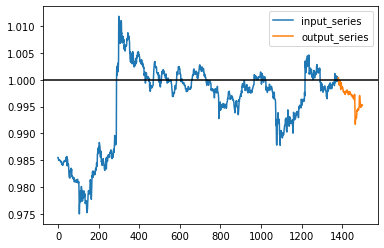

In [ ]:
# sample_id n에 해당하는 sample의 분단위 시가 변동 정보 시각화
n = 1279
idx = n
plot_series(train_x_array[idx,:,1], train_y_array[idx,:,1])
plt.show()

# 모델 훈련


fbprophet이 두개의 칼럼(ds, y)밖에 사용하지 못해서 다른 모델과 합해서 사용해볼까 고민

=> 데이터 확인 후 토의에 따라 다른 칼럼을 일단은 굳이 사용하지 않기로 결정 

train 샘플로 훈련해보기

In [ ]:
start_time = '2021-01-31 00:00:00'
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
print(start_dt)     

2021-01-31 00:00:00


In [ ]:
idx = 1205
x_series = train_x_array[idx,:,1]
y_series = train_y_array[idx,:,1]

In [ ]:
# prophet 모델의 학습을 위한 가공 (ds, y 칼럼이 필요하다.)
x_df = pd.DataFrame()
x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
x_df['y'] = x_series.tolist() 

In [ ]:
x_df.head()

,ds,y
0,2021-01-31 00:01:00,0.937851
1,2021-01-31 00:02:00,0.938050
2,2021-01-31 00:03:00,0.938227
3,2021-01-31 00:04:00,0.938714
4,2021-01-31 00:05:00,0.938249


In [ ]:
model = Prophet(seasonality_mode='multiplicative',# 점점 증가하는 seasonality의 경우 multiplicative를 설정해준다.
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=False,
                  changepoint_range=0.97,  # changepoint range를 바꿔준다. (큰 영향을 끼치지는 않는듯하다.)
                  changepoint_prior_scale=0.1  # 오버피팅, 언더피팅을 피하기 위해 조정해준다.
                )
model.add_seasonality(name='first_seasonality', period=1/8, fourier_order=15) # seasonality 추가
model.add_seasonality(name='second_seasonality', period=1/12, fourier_order=7) # seasonality 추가
#model.add_seasonality(name='third_seasonality', period=1/144, fourier_order=5) # seasonality 추가
model.fit(x_df)

In [ ]:
# 120분 테스트 데이터를 예측
forecast = model.make_future_dataframe(periods=120, freq='min') # 120분을 예측
forecast_data = model.predict(forecast)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5) 

,ds,yhat,yhat_lower,yhat_upper
1495,2021-02-01 00:56:00,0.937680,0.906713,0.969900
1496,2021-02-01 00:57:00,0.937125,0.904651,0.970601
1497,2021-02-01 00:58:00,0.936518,0.904154,0.970831
1498,2021-02-01 00:59:00,0.935866,0.902122,0.970753
1499,2021-02-01 01:00:00,0.935189,0.901877,0.970214


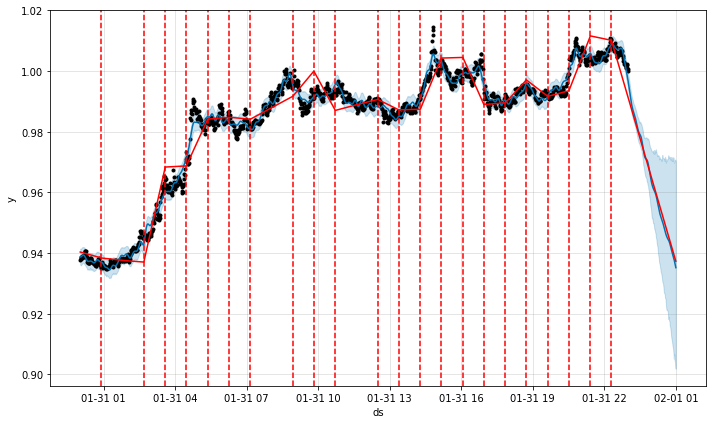

In [ ]:
# 만들어진 데이터를 확인
from fbprophet.plot import add_changepoints_to_plot
fig1 = model.plot(forecast_data)
a = add_changepoints_to_plot(fig1.gca(), model, forecast_data)

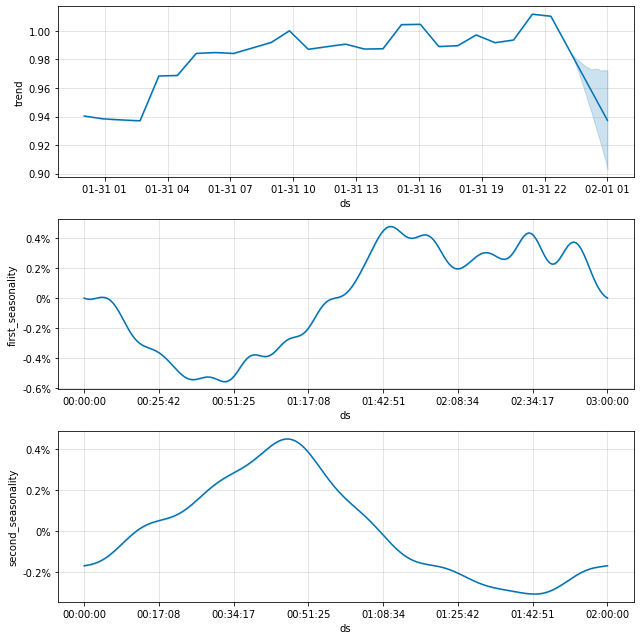

In [ ]:
# 데이터 trend 및 추가한 seasonality 확인
fig2 = model.plot_components(forecast_data)

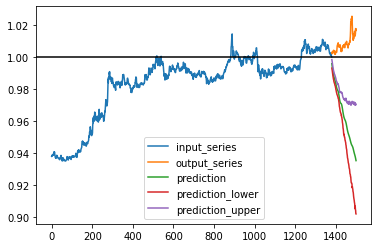

In [ ]:
pred_y = forecast_data.yhat.values[-120:]
pred_y_lower = forecast_data.yhat_lower.values[-120:]
pred_y_upper = forecast_data.yhat_upper.values[-120:]

plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), pred_y, label = 'prediction')
plt.plot(np.arange(1380, 1380+120), pred_y_lower, label = 'prediction_lower')
plt.plot(np.arange(1380, 1380+120), pred_y_upper, label = 'prediction_upper')
plt.legend()
plt.show()

교차검증 분석

 yhat과 y값 사이의 오류를 측정

In [ ]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial = '1259 min', period = '120 min', horizon = '120 min')
df_cv.head(7)

INFO:fbprophet:Making 1 forecasts with cutoffs between 2021-01-31 21:00:00 and 2021-01-31 21:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-01-31 21:01:00,0.987946,0.984375,0.991192,0.987263,2021-01-31 21:00:00
1,2021-01-31 21:02:00,0.988470,0.985160,0.992039,0.986459,2021-01-31 21:00:00
2,2021-01-31 21:03:00,0.989156,0.985961,0.992677,0.985924,2021-01-31 21:00:00
3,2021-01-31 21:04:00,0.989922,0.986504,0.993228,0.985918,2021-01-31 21:00:00
4,2021-01-31 21:05:00,0.990674,0.987073,0.993980,0.985061,2021-01-31 21:00:00
5,2021-01-31 21:06:00,0.991331,0.987979,0.994792,0.985495,2021-01-31 21:00:00
6,2021-01-31 21:07:00,0.991835,0.988295,0.995299,0.984948,2021-01-31 21:00:00


모형 성능 확인

MSE, RMSE, MAE, MAPE 등 확인 가능

In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head(7)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,0 days 00:12:00,0.000029,0.005416,0.005035,0.005108,0.005810,0.166667
1,0 days 00:13:00,0.000032,0.005665,0.005462,0.005541,0.005901,0.083333
2,0 days 00:14:00,0.000035,0.005876,0.005775,0.005857,0.005901,0.000000
3,0 days 00:15:00,0.000035,0.005950,0.005887,0.005970,0.005901,0.000000
4,0 days 00:16:00,0.000037,0.006049,0.006012,0.006096,0.005901,0.000000
5,0 days 00:17:00,0.000038,0.006173,0.006132,0.006217,0.006292,0.000000
6,0 days 00:18:00,0.000040,0.006359,0.006301,0.006389,0.006681,0.000000


이제 n개의 샘플로 학습 및 추론을 해보고 모의 투자를 진행해보자.

In [ ]:
# train 데이터 상단의 n개 샘플로 validation set를 구성하여 학습 및 추론
n = 700
valid_x_df = train_x_df[train_x_df.sample_id < n]
valid_y_df = train_y_df[train_y_df.sample_id < n]

valid_x_array = df2d_to_array3d(valid_x_df)
valid_y_array = df2d_to_array3d(valid_y_df)
valid_pred_array = np.zeros([n, 120])

prediction의 방법 고민

1. 1분 단위로 t일 때의output을 input의 끝에 붙이고 그 다음은 t+1 일 때의 output을 예측하기

2. 바로 120분을 예측

In [ ]:
for idx in tqdm(range(valid_x_array.shape[0])):
    try:
        x_series = valid_x_array[idx,:,1]

        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()

        prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=False,
                  changepoint_range=0.97,  # changepoint range를 바꿔준다. (큰 영향을 끼치지는 않는듯하다.)
                  changepoint_prior_scale=0.1  # 오버피팅, 언더피팅을 피하기 위해 조정해준다.
                  )
        prophet.add_seasonality(name='first_seasonality', period=1/8, fourier_order=15) # seasonality 추가
        prophet.add_seasonality(name='second_seasonality', period=1/12, fourier_order=7) # seasonality 추가
        prophet.fit(x_df)

        # 120분 테스트 데이터를 예측
        future_data = prophet.make_future_dataframe(periods=120, freq='min')
        forecast_data = prophet.predict(future_data)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        valid_pred_array[idx,:] = pred_y
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass


100%|██████████| 700/700 [1:07:02<00:00,  5.75s/it]


In [ ]:
print(valid_pred_array)
print(np.argmax(valid_pred_array,axis=1))

[[1.00128089 1.00125949 1.00126894 ... 1.02272085 1.02269171 1.02262663]
 [0.9991915  0.99900462 0.9987667  ... 1.00306992 1.00290597 1.00252641]
 [0.99802513 0.99799649 0.99806103 ... 1.01198163 1.0116842  1.01147621]
 ...
 [1.00227792 1.00248988 1.00278326 ... 1.02980981 1.03004524 1.03023791]
 [0.99940848 0.99949911 0.999634   ... 1.00269578 1.00244042 1.00226959]
 [1.00028525 1.00043995 1.00054314 ... 1.00691017 1.00694955 1.0069363 ]]
[117  82 110   0   0 112   0 110 119  40   0   0 102  10   4 119   0 115
 119   0   0 105 119  45   3 106  80   0   0 119  70   7  59   0   3 102
 119 119   3 119   0  55   0  50   5 114 119 119 119   0 119  77 119   0
   0  93 119 119   0 103 119  90   0   2 117 119   6   3  47   0 119 119
  32 119 119   0   0  23 119   6 106   8   0  25 108   0 119  61  70  49
   5  84  23   0 111 119  24   0  51  79 119  15  58   8  66 117   0  46
   0   0 117  18 119  98 104 118  90 101  50   0  76  47   0  67   9   0
   0  87   0   7   0  50 119   2  55   0   0 

n%를 기준으로 100% 매수를 선택한 이유
- 529번의 기회동안 n%가 오를거라 예측하는 샘플은 많지 않을 것
- 대회의 특성상 안전하게 낮은 점수를 받는 것 보다는 위험을 감수하고 큰 점수를 받는 것이 낫다

In [ ]:
def array_to_submission(x_array, pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantitiy와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)
    # 11% 초과 상승으로 예측한 sample에 대해서만 100% 매수  + 11% 이하 8.5% 초과 상승으로 예측한 sample에 대해서 40% 매수
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.11) * 0.6 + (buy_price>1.085)  * 0.4
    # 모델의 예측값 중 최대 값에 해당하는 시간에 매도
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

In [ ]:
valid_submission = array_to_submission(valid_x_array, valid_pred_array)

In [ ]:
valid_submission

,sample_id,buy_quantity,sell_time
0,0,0.0,117
1,1,0.0,82
2,2,0.0,110
3,3,0.0,0
4,4,0.0,0
...,...,...,...
995,995,0.0,119
996,996,0.0,119
997,997,0.0,119
998,998,0.0,111


In [ ]:
# 위에서 학습한 n가지 sample에 대해
# i가지 case에서 설정한 % 이상 상승한다고 추론함.
valid_submission.buy_quantity.value_counts()

0.0    985
1.0      9
0.4      6
Name: buy_quantity, dtype: int64

In [ ]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index


def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id정보를 index에 저장
    y_array, index = df2d_to_answer(y_df)
    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index, :]    
    
    # 초기 투자 비용은 10000 달러
    total_momey      = 10000 # dollars
    total_momey_list = []
    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time  = submission.loc[row_idx, 'sell_time']
        buy_price  = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_momey
        residual = total_momey - buy_quantity
        ratio = sell_price / buy_price
        total_momey = buy_quantity * ratio * 0.9995 * 0.9995 + residual        
        total_momey_list.append(total_momey)
        
    return total_momey, total_momey_list

In [ ]:
total_momey, total_momey_list = COIN(valid_y_df, valid_submission)

In [ ]:
# 투자 후 금액
print(total_momey)

In [ ]:
# 투자 히스토리
plt.plot(total_momey_list)
plt.title("history")
plt.show()

In [ ]:
test_pred_array = np.zeros([test_x_array.shape[0],
                           120])
for idx in tqdm(range(test_x_array.shape[0])):
    try:
        x_series = test_x_array[idx,:,1]

        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()
    
        prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=False,
                  changepoint_range=0.97,  # changepoint range를 바꿔준다. (큰 영향을 끼치지는 않는듯하다.)
                  changepoint_prior_scale=0.1  # 오버피팅, 언더피팅을 피하기 위해 조정해준다.
                  )
        prophet.add_seasonality(name='first_seasonality', period=1/8, fourier_order=15) # seasonality 추가
        prophet.add_seasonality(name='second_seasonality', period=1/12, fourier_order=7) # seasonality 추가
        prophet.fit(x_df)

        # 120분 테스트 데이터를 예측
        future_data = prophet.make_future_dataframe(periods=120, freq='min')
        forecast_data = prophet.predict(future_data)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        test_pred_array[idx,:] = pred_y
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

100%|██████████| 529/529 [48:54<00:00,  5.55s/it]


In [ ]:
submission = array_to_submission(test_x_array, test_pred_array)

In [ ]:
submission.to_csv(path+"/coin_submission19.csv", index = False)